In [3]:
import netket as nk
import jax.numpy as jnp
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
from scipy.sparse.linalg import eigsh
import jax
from netket.operator.spin import sigmax,sigmaz
import jax.flatten_util
import pickle
from typing import Union, Any
import numpy as np
import jax
from jax import numpy as jnp
from flax import linen as nn
from jax.nn.initializers import normal
from netket.utils.types import NNInitFunc
from netket import nn as nknn
default_kernel_init = normal(stddev=0.01)
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from tqdm import trange
import time
from sklearn.decomposition import PCA, KernelPCA

In [4]:
runs_dict = {'energies': {}, 'energies_exact': {}, 'energies_error': {}, 'infid': {}, 'hs': {}}

def get_psi(vstate,hi,model):
    '''
    Function that returns a vector with the wavefunction probability amplitudes

    Inputs ---
    vsate: Netket's vstate object, the variational quantum state
    hi:    Hilbert space 
    model: Instance of RBM model

    Outputs ---
    psi:   Vector of probability amplitudes indexed all possible by configurations/eigenstates of the Hilbert space

    '''
    parameters = vstate.variables
    all_configurations = hi.all_states()

    logpsi = model.apply(parameters,all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi/ jnp.linalg.norm(psi)

    return psi

    
def hidden_activations(params, v):
    """
    Compute the activations of the hidden units given the visible units using log(cosh).
    h_probs = log(cosh(v @ W + c))
    """
    W, c = params['Dense']['kernel'], params['Dense']['bias']
    pre_activation = v @ W + c  # Linear transformation
    h_probs = nk.nn.activation.log_cosh(pre_activation)  # Log-cosh activation
    return h_probs

def infidelity(wavefunc1, wavefunc2):

    norm = np.linalg.norm(wavefunc1)*np.linalg.norm(wavefunc2)
    overlap = np.dot(np.conjugate(wavefunc1), wavefunc2)
    fidelity = np.abs(overlap)**2/norm

    return 1 - fidelity

def get_weights(vstate):
    '''
    Function that returns flattened array containing the RBM weights

    Input:      Netket's vstate object, the variational quantum state. 
    Output:     Flattened 1D array with RBM weights
    '''

    rbm_params = vstate.parameters

    weights = rbm_params['Dense']['kernel']
    
    return jnp.ravel(weights)

In [100]:
N = 8
J = -1  
g = nk.graph.Chain(length=N, pbc=False) 
hilbert = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
hamiltonian = nk.operator.Ising(hilbert, h=3.0, graph=g)
wv = nk.exact.lanczos_ed(hamiltonian, k=1, compute_eigenvectors=True)
exact_energy, exact_wavefunc = wv[0][0], wv[1].reshape(-1)
magnetizations = hilbert.all_states().sum(1)/N
model = nk.models.RBM(alpha = 2)
vstate = nk.vqs.FullSumState(hilbert, model)
optimizer = nk.optimizer.Adam(learning_rate=0.001)
variance = []
energy = []
number_of_runs = 2 #if i == 0 else 1
gs = nk.driver.VMC(hamiltonian,optimizer,variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))
for _ in range(number_of_runs):
    gs = nk.driver.VMC(hamiltonian,optimizer,variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))
    log = nk.logging.RuntimeLog()
    gs.run(n_iter=1000,out=log,show_progress=False)
    energy.extend(log['Energy']['Mean'])
    variance.extend(log['Energy']['Variance'])



In [101]:
N = 8
J = -1  
g = nk.graph.Chain(length=N, pbc=False) 
hilbert = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
hamiltonian = nk.operator.Ising(hilbert, h=3.0, graph=g)
wv = nk.exact.lanczos_ed(hamiltonian, k=1, compute_eigenvectors=True)
exact_energy, exact_wavefunc = wv[0][0], wv[1].reshape(-1)
magnetizations = hilbert.all_states().sum(1)/N
model = nk.models.RBM(alpha = 2)
vstate = nk.vqs.FullSumState(hilbert, model)
variance = []
energy2 = []
number_of_runs = 1 #if i == 0 else 1

energy2 = []
n_steps = 1000
for _ in range(2):
    optimizer = nk.optimizer.Adam()
    for i in range(n_steps):
        E, E_grad = vstate.expect_and_grad(hamiltonian)
        energy2.append(E.mean.real)
        new_params = jax.tree_util.tree_map(lambda x,y: x-0.001*y, vstate.parameters, E_grad)
        vstate.parameters = new_params

In [137]:
N = 8
J = -1  
g = nk.graph.Chain(length=N, pbc=False) 
hilbert = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
hamiltonian = nk.operator.Ising(hilbert, h=3.0, graph=g)
wv = nk.exact.lanczos_ed(hamiltonian, k=1, compute_eigenvectors=True)
exact_energy, exact_wavefunc = wv[0][0], wv[1].reshape(-1)
magnetizations = hilbert.all_states().sum(1)/N
model = nk.models.RBM(alpha = 2)
vstate = nk.vqs.FullSumState(hilbert, model)
optimizer = nk.optimizer.Adam(learning_rate = 0.001)
variance = []
energy3 = []
number_of_runs = 2000 #if i == 0 else 1
gs = nk.driver.VMC(hamiltonian,optimizer,variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))
for i in range(number_of_runs):
    if i == 500: 
        #     gs = nk.driver.VMC(hamiltonian,optimizer,variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.01))
    
    log = nk.logging.RuntimeLog()
    gs.run(n_iter=1,out=log,show_progress=False)
    energy3.extend(log['Energy']['Mean'])
    variance.extend(log['Energy']['Variance'])



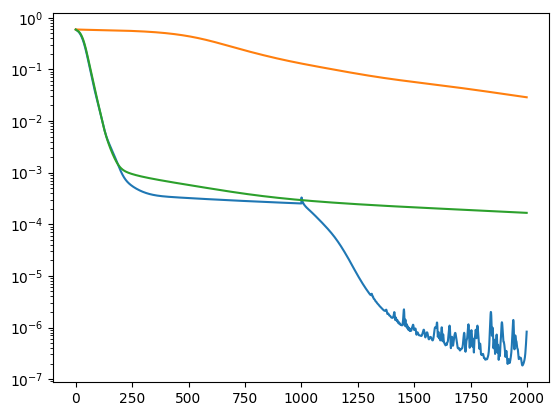

In [138]:
plt.plot(energy - exact_energy)
plt.plot(energy2 - exact_energy)
plt.plot(energy3 - exact_energy)
plt.yscale('log')